In [2]:
import numpy as np
import pandas as pd
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from data.get_results import get_results
from gp_utils import get_kernel
from acquisitions import generate_mixture_acq, mixture_acq, generate, log_likelihood, get_likelihood_utility

In [2]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

## Simulate actions with negative quadratic reward


In [3]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
fmax = np.argmax(neg_quad)

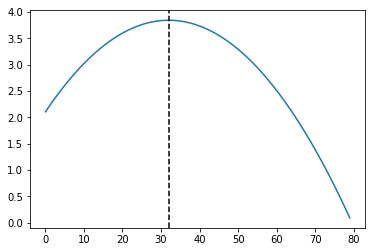

In [4]:
plt.plot(neg_quad);
plt.axvline(x=fmax, ls='--', c='black');

In [5]:
steepness_params = np.array([1, 0, 0])
x_midpoint_params = np.array([10, 0, 0])
yscale_params = np.array([1, 0, 0])
phase_temp_params = np.array([.01, .01, .01])

learning_rate_params = np.array([0, 0, 0])
stay_penalty_params = np.array([0, 100, 0])
local_temp_params = np.array([.1, .1, .1])
    
mes_temp_params = np.array([.1, .1, .1])
mixture_params = np.array([[1, .0, .0], [.0, 1, .0], [0, 0, 1]])

In [6]:
true_params = {"learning_rate": learning_rate_params,
                   "stay_penalty": stay_penalty_params,
                   "local_temperature": local_temp_params,
                   "steepness": steepness_params,
                   "x_midpoint": x_midpoint_params,
                   "yscale": yscale_params,
                   "phase_ucb_temperature": phase_temp_params,
                   "mes_temperature": mes_temp_params,
                   "mixture": mixture_params}

In [7]:
data = generate1(mixture_acq1, true_params, neg_quad_kern, neg_quad, 15, 20, 3, np.array([.333, .333, .333]))

In [8]:
actions = data[:,9,:].argmax(axis=1)

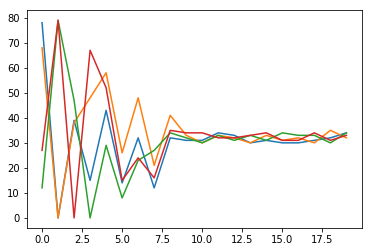

In [9]:
plt.plot(actions[:4].T);

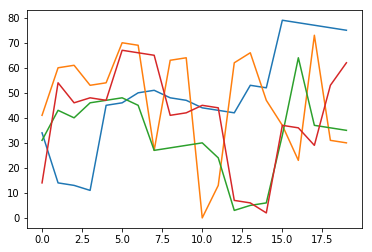

In [10]:
plt.plot(actions[4:8].T);

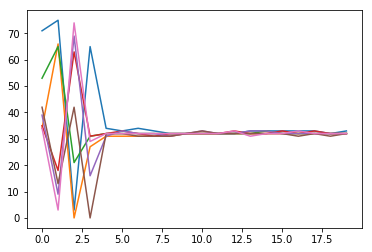

In [11]:
plt.plot(actions[8:].T);

In [12]:
log_likelihood(data, mixture_acq1, true_params, 3, np.array([.333, .333, .333]))

-220.56554514475715

In [13]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [14]:
k = 15

smp_steepness_params = pm.Gamma.dist(1., 1., shape=k).random()
smp_x_midpoint_params = pm.Uniform.dist(0, 20, shape=k).random()
smp_yscale_params = pm.Gamma.dist(1., 1., shape=k).random()
smp_phase_temp_params = pm.Gamma.dist(.1, .1, shape=k).random()

smp_learning_rate_params = pm.Gamma.dist(25., .1, shape=k).random()
smp_stay_penalty_params = pm.Gamma.dist(.1, .1, shape=k).random()
smp_local_temp_params = pm.Gamma.dist(.1, .1, shape=k).random()
    
smp_mes_temp_params = pm.Gamma.dist(.1, .1, shape=k).random()
smp_mixture_params = pm.Dirichlet.dist(np.array([1., 1., 1.]), shape=(k,3)).random()

In [15]:
smp_params =   {"learning_rate": smp_learning_rate_params,
                "stay_penalty": smp_stay_penalty_params,
                "local_temperature": smp_local_temp_params,
                "steepness": smp_steepness_params,
                "x_midpoint": smp_x_midpoint_params,
                "yscale": smp_yscale_params,
                "phase_ucb_temperature": smp_phase_temp_params,
                "mes_temperature": smp_mes_temp_params,
                "mixture": smp_mixture_params}

In [16]:
smp_alpha = pm.Gamma.dist(1., 1.).random()
smp_beta = pm.Beta.dist(1., smp_alpha, shape=k).random()
smp_w = stick_breaking(smp_beta).eval()

In [17]:
log_likelihood(data, mixture_acq1, smp_params, k, smp_w)

-147.24557377818056

## Infinite Mixture

In [18]:
rerun_inf_mix = True

In [19]:
k=15

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [20]:
if rerun_inf_mix:
    with pm.Model() as model:
        
        steepness = pm.Gamma('steepness', 1., 1., shape=k)
        x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=k)
        yscale = pm.Gamma('yscale', 1., 1., shape=k)
        phase_temperature = pm.Gamma('phase_temperature', .1, .1, shape=k)
        
        learning_rate = pm.Gamma('learning_rate', 25., .1, shape=k)
        stay_penalty = pm.Gamma('stay_penalty', .1, .1, shape=k)
        local_temperature = pm.Gamma('local_temperature', .1, .1, shape=k)
        
        mes_temperature = pm.Gamma('mes_temperature', .1, .1, shape=k)
        mixture = pm.Dirichlet('mixture', np.array([1., 1., 1.]), shape=(k,3))
        
        alpha = pm.Gamma('alpha', 1., 1.)
        beta = pm.Beta('beta', 1., alpha, shape=k)
        w = pm.Deterministic('w', stick_breaking(beta))
        
        params = {"learning_rate": learning_rate,
                   "stay_penalty": stay_penalty,
                   "local_temperature": local_temperature,
                   "steepness": steepness,
                   "x_midpoint": x_midpoint,
                   "yscale": yscale,
                   "phase_ucb_temperature": phase_temperature,
                   "mes_temperature": mes_temperature,
                   "mixture": mixture}

        obs = pm.Potential('obs', log_likelihood(data, mixture_acq2, params, k, w))
        inf_mix_trace = pm.sample(200, njobs=1)
        with open('mix_inf_mix_trace.pkl', 'wb') as f:
            pickle.dump(inf_mix_trace, f)
else:
    with open('mix_inf_mix_trace.pkl', 'rb') as f:
        inf_mix_trace = pickle.load(f)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha, mixture, mes_temperature, local_temperature, stay_penalty, learning_rate, phase_temperature, yscale, x_midpoint, steepness]
100%|██████████| 700/700 [16:08:39<00:00, 61.71s/it]  
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


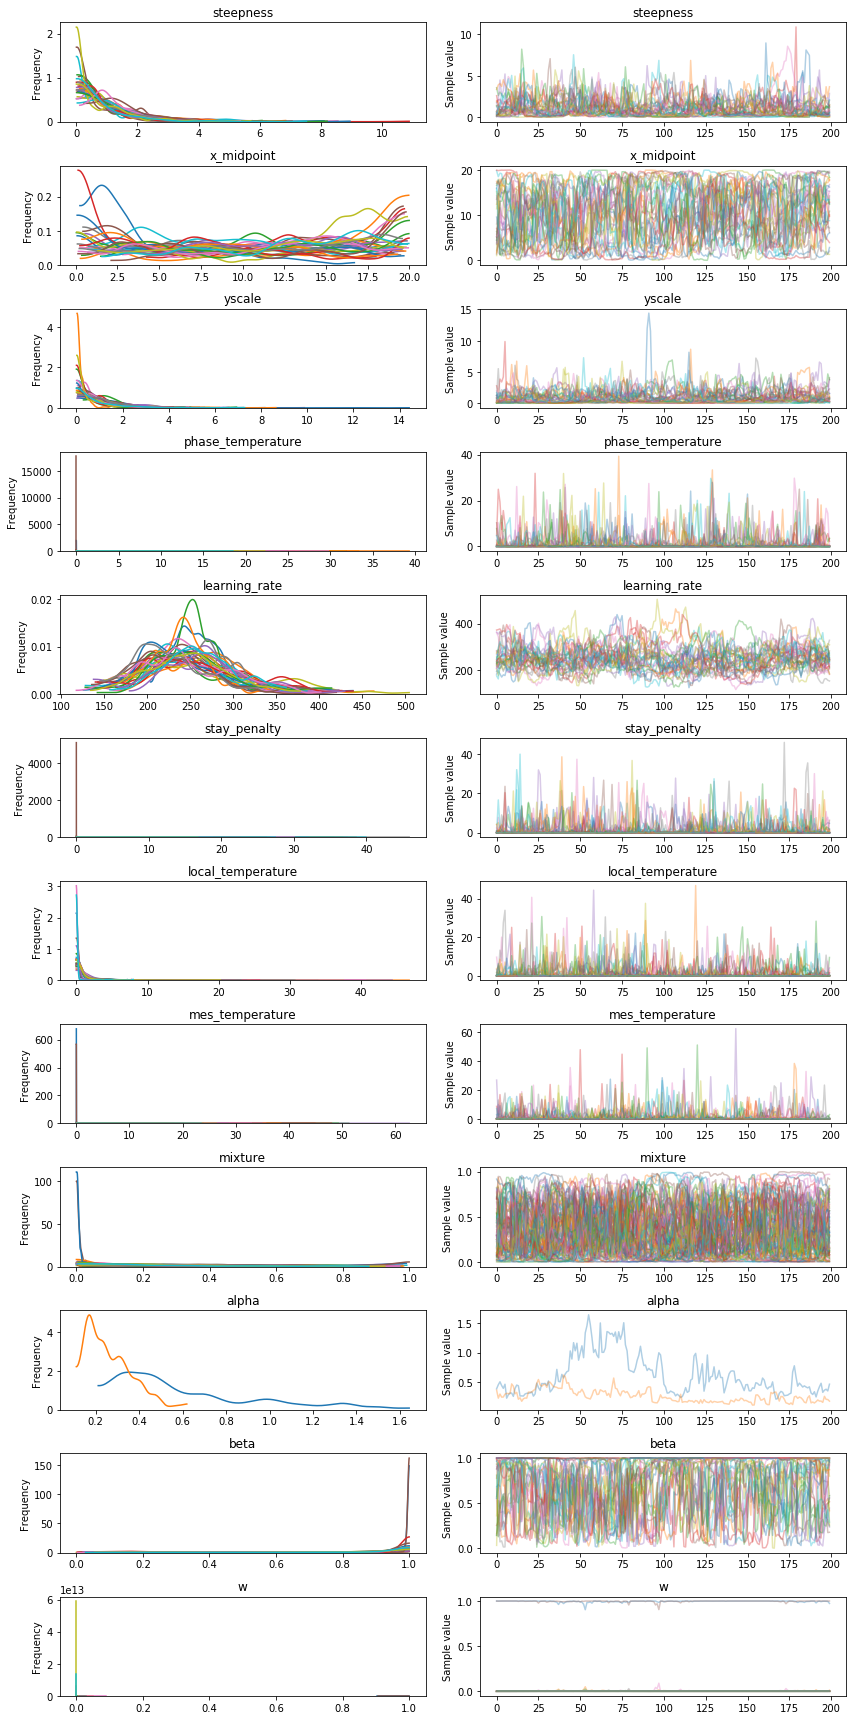

In [22]:
pm.traceplot(inf_mix_trace);

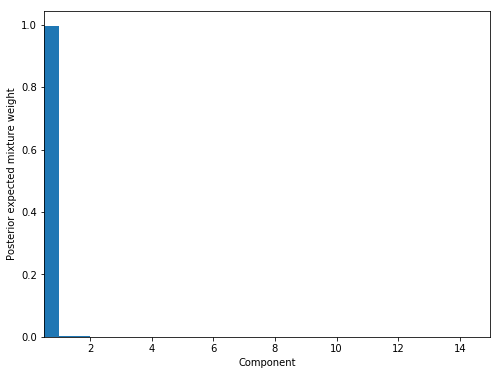

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_w = np.arange(k) + 1
ax.bar(plot_w - 0.5, inf_mix_trace['w'].mean(axis=0), width=1., lw=0);
ax.set_xlim(0.5, k);
ax.set_xlabel('Component');
ax.set_ylabel('Posterior expected mixture weight');

In [35]:
inf_mix_trace['w'].mean(axis=0)

array([9.96301452e-01, 2.53022157e-03, 6.51698155e-04, 2.11549493e-04,
       1.16774909e-04, 1.05913118e-04, 4.55685695e-05, 1.21329672e-05,
       1.21869680e-05, 2.89281245e-06, 4.26519005e-06, 1.94052778e-06,
       1.97278946e-06, 7.50756579e-07, 3.47422854e-07])

In [32]:
trials = np.arange(20)
def phase_ucb_clusters(trace, threshold):
    
    mean_weights = trace['w'].mean(axis=0)
    idx = np.argwhere(mean_weights>=threshold).ravel()
    samples = np.array([[s['steepness'], s['x_midpoint'], s['yscale']] for s in np.array(trace)])[:,:,idx]
    
    position = trials[:,None,None] - samples[:,1,:]
    growth = np.exp(-samples[:,0,:] * position)
    denom = 1 + samples[:,2,:] * growth
    e = 1 - 1. / denom

    mean_e = e.mean(axis=1)
    std_e = e.std(axis=1)
    return mean_e, std_e

In [33]:
def plot_phase_ucb_clusters(mean_e, std_e):
    
    mean_e = mean_e.T
    std_e = std_e.T
    colors = np.array(sns.color_palette("hls", mean_e.shape[0]).as_hex())
    upper = (mean_e + 2 * std_e).clip(min=0, max=1)
    lower = (mean_e - 2 * std_e).clip(min=0, max=1)
    for i in range(len(mean_e)):
        plt.plot(mean_e[i], color=colors[i])
        plt.fill_between(np.arange(len(mean_e[i])), lower[i], upper[i], color=colors[i], alpha=.5)

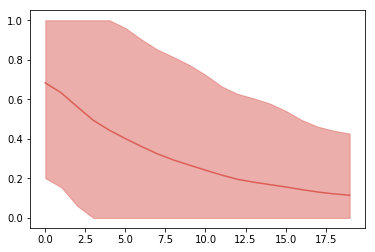

In [34]:
mean_e, std_e = phase_ucb_clusters(inf_mix_trace, .2)
plot_phase_ucb_clusters(mean_e, std_e)

In [66]:
def local_clusters(trace, threshold):
    
    mean_weights = trace['w'].mean(axis=0)
    idx = np.argwhere(mean_weights>=threshold).ravel()
    samples = np.array([[s['learning_rate'], s['stay_penalty'], s['local_temperature'],
                        s['steepness'], s['x_midpoint'], s['yscale'], s['phase_temperature'],
                        s['mes_temperature']] for s in np.array(trace)])[:,:,idx]
    
    mixture_weights = np.array([[s['mixture']] for s in np.array(trace)])[:,:,idx]
    return samples, mixture_weights

In [67]:
samples, mixture_weights = local_clusters(inf_mix_trace, .2)

In [71]:
p = samples.mean(axis=0)

In [78]:
m = mixture_weights.mean(axis=0)[0]

In [79]:
learned_params =   {"learning_rate": p[0],
                "stay_penalty": p[1],
                "local_temperature": p[2],
                "steepness": p[3],
                "x_midpoint": p[4],
                "yscale": p[5],
                "phase_ucb_temperature": p[6],
                "mes_temperature": p[7],
                "mixture": m}

In [80]:
new_data = generate1(mixture_acq1, learned_params, neg_quad_kern, neg_quad, 30, 20, 1, np.array([1]))

In [81]:
actions = new_data[:,8,:].argmax(axis=1)

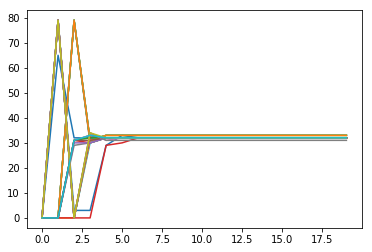

In [82]:
plt.plot(actions.T);